In [246]:
# !pip install pycocoevalcap
# !pip install nltk
# !pip install rouge-score

In [247]:
from pycocoevalcap.eval import COCOEvalCap
from pycocotools.coco import COCO
import json
import csv
import pandas as pd

# Convert to JSON Format

In [248]:
def csv_to_coco_json_fixed_ids(groundtruth_path, name_map_path, output_path):
    """
    Converts a ground truth CSV and a name map CSV to COCO JSON format,
    ensuring IDs start from 1 sequentially.
    
    :param groundtruth_path: Path to the ground truth CSV file containing image names and captions.
    :param name_map_path: Path to the CSV file mapping image names to IDs.
    :param output_path: Path to save the COCO JSON file.
    """
    # Load the CSV files
    groundtruth_df = pd.read_csv(groundtruth_path)
    name_map_df = pd.read_csv(name_map_path)

    # Create a dictionary mapping image names to IDs
    original_image_map = dict(zip(name_map_df.iloc[:, 0], name_map_df.iloc[:, 1]))

    # Normalize IDs to start from 1 sequentially
    unique_names = sorted(original_image_map.keys())
    normalized_image_map = {name: idx + 1 for idx, name in enumerate(unique_names)}

    # Create annotations in COCO JSON format
    annotations = []
    for _, row in groundtruth_df.iterrows():
        image_name = row['image_name'].strip()
        caption = row['captions'].strip()
        image_id = normalized_image_map.get(image_name, None)
        if image_id is not None:
            annotations.append({
                "image_id": image_id,
                "caption": caption
            })

    # Prepare the COCO JSON structure
    coco_json = {"annotations": annotations}

    # Save the output JSON file
    with open(output_path, 'w') as json_file:
        json.dump(coco_json, json_file, indent=4)

    print(f"COCO JSON file created: {output_path}")


# Run the cells only once! [To convert csv files to json files]

In [249]:
# csv_to_coco_json(
#     groundtruth_path="./captions/groundtruth-captions.csv"  ,
#     name_map_path="./captions/name-map.csv",
#     output_path="./captions/groundtruth-captions.json" 
# )



# csv_to_coco_json(
#     groundtruth_path="./captions/groundtruth-captions.csv"  ,
#     name_map_path="./captions/name-map.csv",
#     output_path="./captions/groundtruth-captions.json" 
# )


# csv_to_coco_json(
#     groundtruth_path="./captions/blip-conditional-captions.csv"  ,
#     name_map_path="./captions/name-map.csv",
#     output_path="./captions/blip-conditional-captions.json" 
# )



# csv_to_coco_json(
#     groundtruth_path="./captions/blip-unconditional-captions.csv"  ,
#     name_map_path="./captions/name-map.csv",
#     output_path="./captions/blip-unconditional-captions.json" 
# )



# csv_to_coco_json(
#     groundtruth_path="./captions/vit-gpt2-captions.csv"  ,
#     name_map_path="./captions/name-map.csv",
#     output_path="./captions/vit-gpt2-captions.json" 
# )



# csv_to_coco_json(
#     groundtruth_path="./captions/git.csv"  ,
#     name_map_path="./captions/name-map.csv",
#     output_path="./captions/git.json" 
# )




In [250]:
import json
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from nltk.translate.chrf_score import sentence_chrf
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import nltk
import sys

# Download necessary NLTK data
nltk.download('punkt')


[nltk_data] Downloading package punkt to /Users/biraj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [251]:
def load_annotations(file_path):
    """Load annotations from a JSON file."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            annotations = {}
            for item in data['annotations']:
                image_id = item.get('image_id')
                caption = item.get('caption')
                if image_id is not None and caption is not None:
                    annotations[image_id] = caption
                else:
                    print(f"Warning: Missing 'image_id' or 'caption' in item: {item}")
            return annotations
    except FileNotFoundError:
        print(f"Error: '{file_path}' not found.")
        sys.exit(1)
    except json.JSONDecodeError:
        print(f"Error: '{file_path}' is not a valid JSON file.")
        sys.exit(1)

In [252]:
def compute_bleu_scores(ground_truth, predicted, n):
    """Compute BLEU-n scores for each image."""
    common_ids = set(ground_truth.keys()) & set(predicted.keys())
    if not common_ids:
        print("Error: No matching image IDs found between ground truth and predictions.")
        sys.exit(1)

    ground_truth = {k: ground_truth[k] for k in common_ids}
    predicted = {k: predicted[k] for k in common_ids}

    scores = {}
    smoothing = SmoothingFunction().method1

    for image_id in common_ids:
        reference = ground_truth[image_id]
        hypothesis = predicted[image_id]

        reference_tokens = word_tokenize(reference.lower())
        hypothesis_tokens = word_tokenize(hypothesis.lower())

        weights = tuple((1.0 / n if i < n else 0) for i in range(n))
        try:
            score = sentence_bleu([reference_tokens], hypothesis_tokens, weights=weights, smoothing_function=smoothing)
            scores[image_id] = score
        except Exception as e:
            print(f"Error computing BLEU-{n} for image_id {image_id}: {e}")

    return scores

In [253]:
def compute_meteor_scores(ground_truth, predicted):
    """Compute METEOR scores for each image."""
    common_ids = set(ground_truth.keys()) & set(predicted.keys())
    if not common_ids:
        print("Error: No matching image IDs found between ground truth and predictions.")
        sys.exit(1)

    ground_truth = {k: ground_truth[k] for k in common_ids}
    predicted = {k: predicted[k] for k in common_ids}

    scores = {}
    for image_id in common_ids:
        reference = ground_truth[image_id]
        hypothesis = predicted[image_id]

        # Tokenize the sentences
        reference_tokens = word_tokenize(reference.lower())
        hypothesis_tokens = word_tokenize(hypothesis.lower())

        # Compute METEOR score
        try:
            score = single_meteor_score(reference_tokens, hypothesis_tokens)
            scores[image_id] = score
        except Exception as e:
            print(f"Error computing METEOR for image_id {image_id}: {e}")

    return scores





In [254]:
def calculate_average_score(scores, flag = 0):
    if flag == 'meteor':
        title = "Average METEOR score:  "
    if flag == 'bleu-1':
        title = "Average BLEU-1 score:  "
    if flag == 'bleu-2':
        title = "Average BLEU-2 score:  "            
    if scores:
        total_score = sum(scores.values())
        average_meteor = total_score / len(scores)
        average_meteor = round(average_meteor, 4)
        print(title + str(average_meteor))
        return average_meteor
    else:
        print("No METEOR scores were calculated.")
        sys.exit(1)


In [255]:

def visualize_scores(scores,flag=0):

    """Visualize METEOR scores."""
    image_ids = list(scores.keys())
    scores = list(scores.values())

    if flag == "meteor":
        x_y_label = 'METEOR SCORE'
        title1 = 'METEOR Scores per Image'
        title2 = 'Distribution of METEOR Scores'

    if flag == "bleu-1":
        x_y_label = 'BLEU-1 SCORE'
        title1 = 'BLEU-1 Scores per Image'
        title2 = 'Distribution of BLEU-1 Scores'
        
    if flag == "bleu-2":
        x_y_label = 'BLEU-2 SCORE'
        title1 = 'BLEU-2 Scores per Image'
        title2 = 'Distribution of BLEU-2 Scores'
    # Bar Chart of METEOR Scores
    plt.figure(figsize=(10, 6))
    plt.bar(image_ids, scores, color='skyblue')
    plt.xlabel('Image ID')
    plt.ylabel(x_y_label)
    plt.title(title1)
    plt.xticks(rotation=90)
    plt.tight_layout()
    # plt.savefig('meteor_scores_bar_chart.png')
    plt.show()
    plt.close()

    # Histogram of METEOR Scores
    plt.figure(figsize=(8, 6))
    plt.hist(scores, bins=20, color='salmon', edgecolor='black')
    plt.xlabel(x_y_label)
    plt.ylabel('Frequency')
    plt.title(title2)
    plt.tight_layout()
    plt.show()
    plt.close()


In [256]:
def main_func(predictions_file, groundtruth_file,flag=0):
    ground_truth = load_annotations(groundtruth_file)
    predicted = load_annotations(predictions_file)
    if flag == 'meteor':
        meteor_scores = compute_meteor_scores(ground_truth, predicted)
        calculate_average_score(meteor_scores,flag = 'meteor')
        visualize_scores(meteor_scores,flag = 'meteor')
    if flag == 'bleu-1':
        bleu_scores = compute_bleu_scores(ground_truth, predicted,1)
        calculate_average_score(bleu_scores,flag = 'bleu-1')
        visualize_scores(bleu_scores,flag = 'bleu-1')
    if flag == 'bleu-2':
        bleu_scores = compute_bleu_scores(ground_truth, predicted,2)
        calculate_average_score(bleu_scores,flag = 'bleu-2')
        visualize_scores(bleu_scores,flag = 'bleu-2')


# METEOR Distribution vit-gpt2 with Ground Truth

Average METEOR score:  0.1644


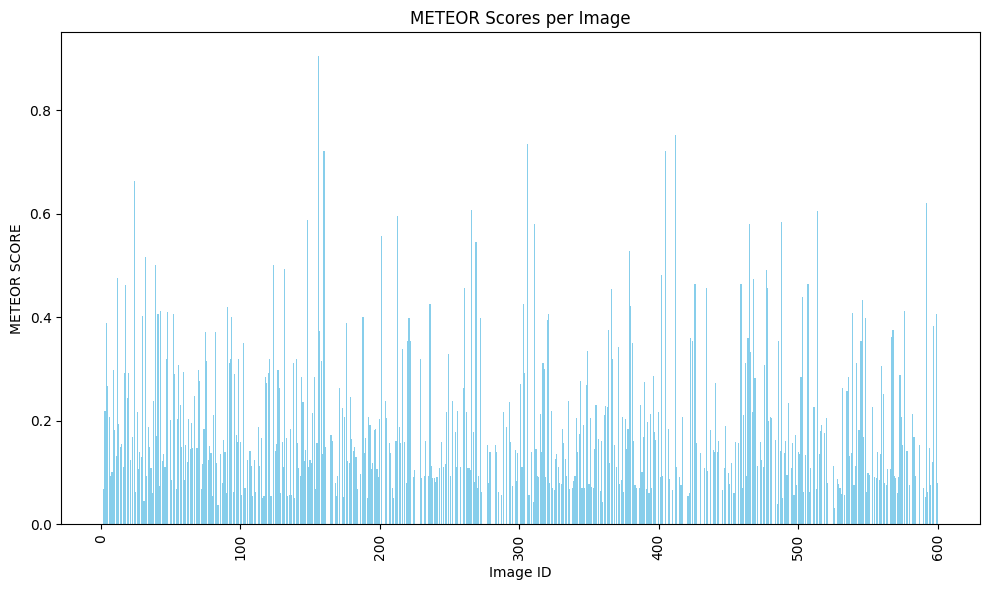

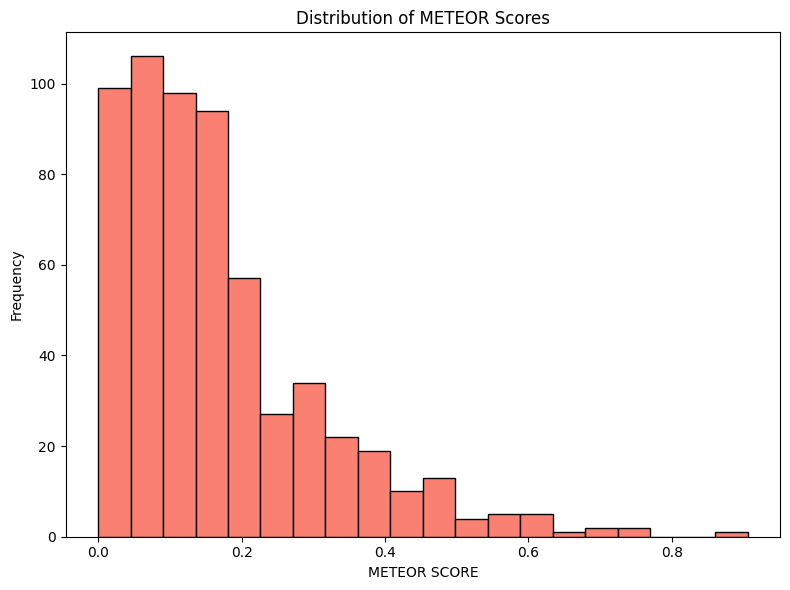

In [257]:
groundtruth_file = "./captions/groundtruth-captions.json"  
predictions_file = "./captions/vit-gpt2-captions.json"  
main_func(predictions_file, groundtruth_file,flag="meteor")

# BLEU-1 Distribution vit-gpt2 with Ground Truth

Average BLEU-1 score:  0.1845


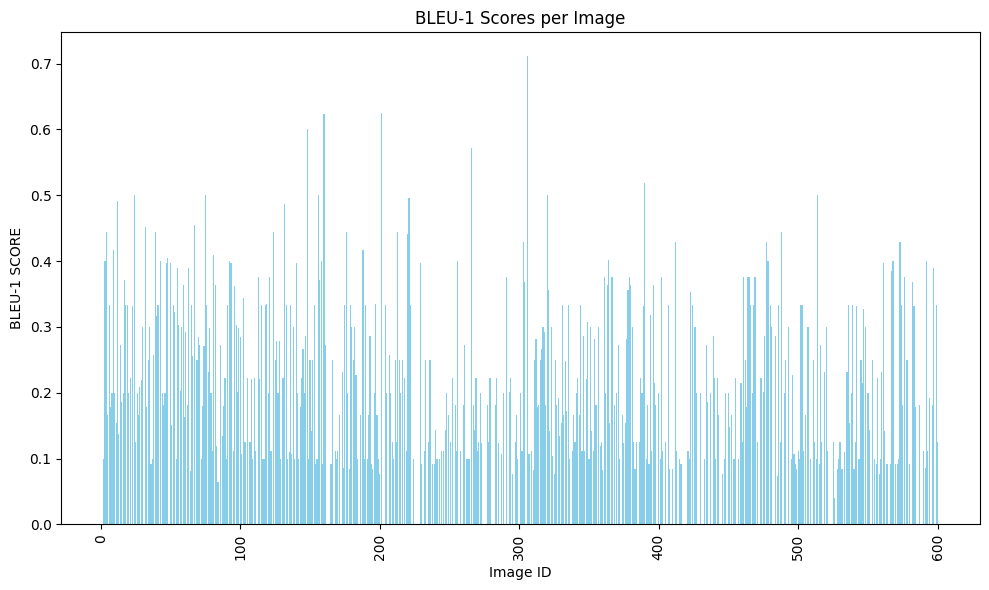

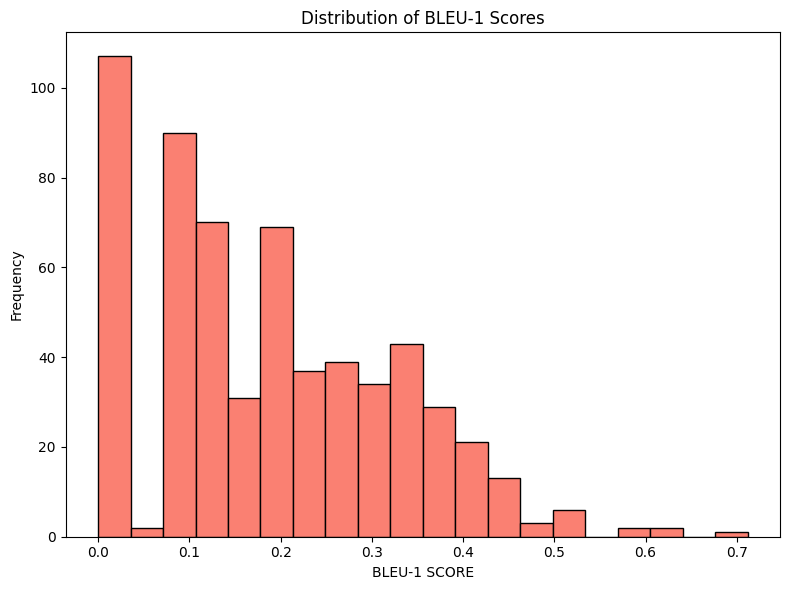

In [258]:
groundtruth_file = "./captions/groundtruth-captions.json"  
predictions_file = "./captions/vit-gpt2-captions.json"  
main_func(predictions_file, groundtruth_file,flag="bleu-1")


# BLEU-2 Distribution vit-gpt2 with Ground Truth

Average BLEU-2 score:  0.0816


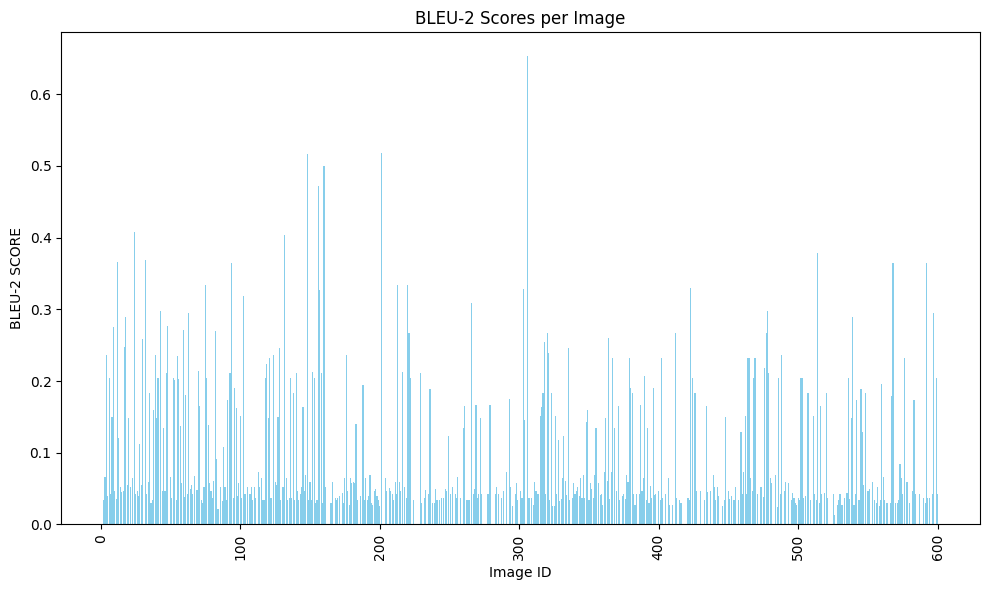

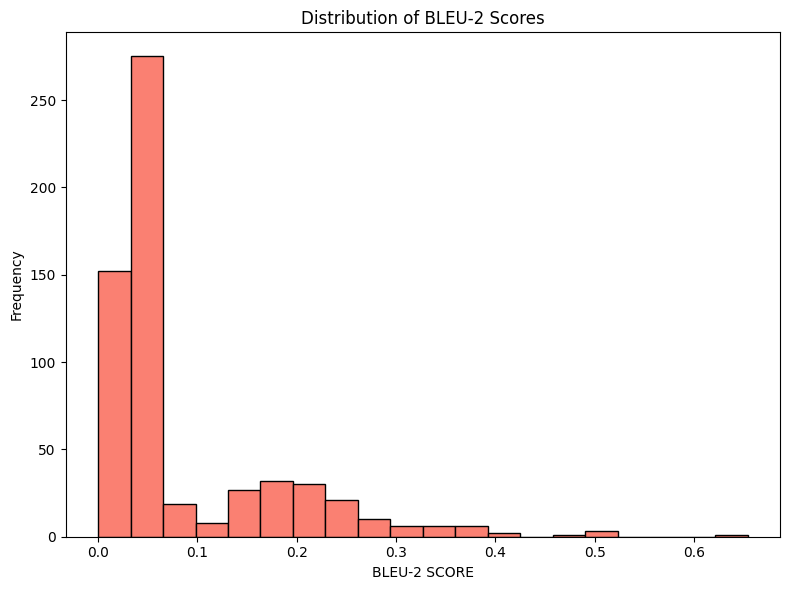

In [259]:
groundtruth_file = "./captions/groundtruth-captions.json"  
predictions_file = "./captions/vit-gpt2-captions.json"  
main_func(predictions_file, groundtruth_file,flag="bleu-2")

# METEOR Distribution Git with Ground Truth

Average METEOR score:  0.2207


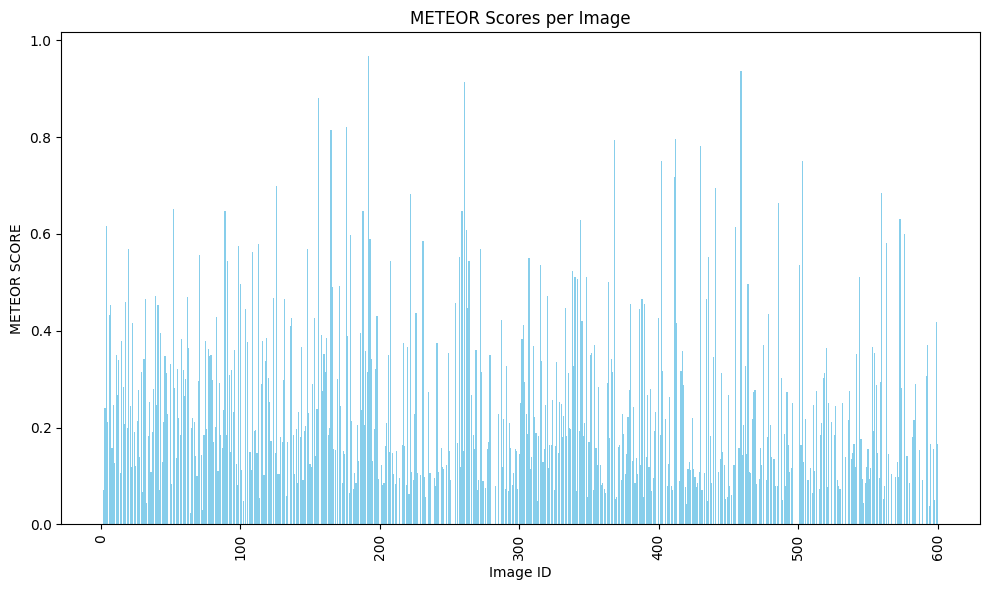

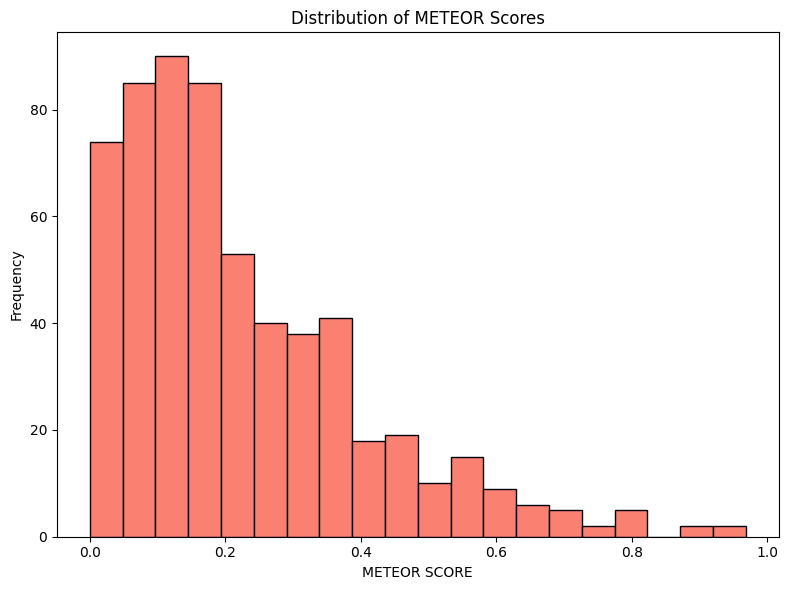

In [260]:
groundtruth_file = "./captions/groundtruth-captions.json"  
predictions_file = "./captions/git.json"  
main_func(predictions_file, groundtruth_file,flag = 'meteor')

# BLEU-1 Distribution Git with Ground Truth

Average BLEU-1 score:  0.2301


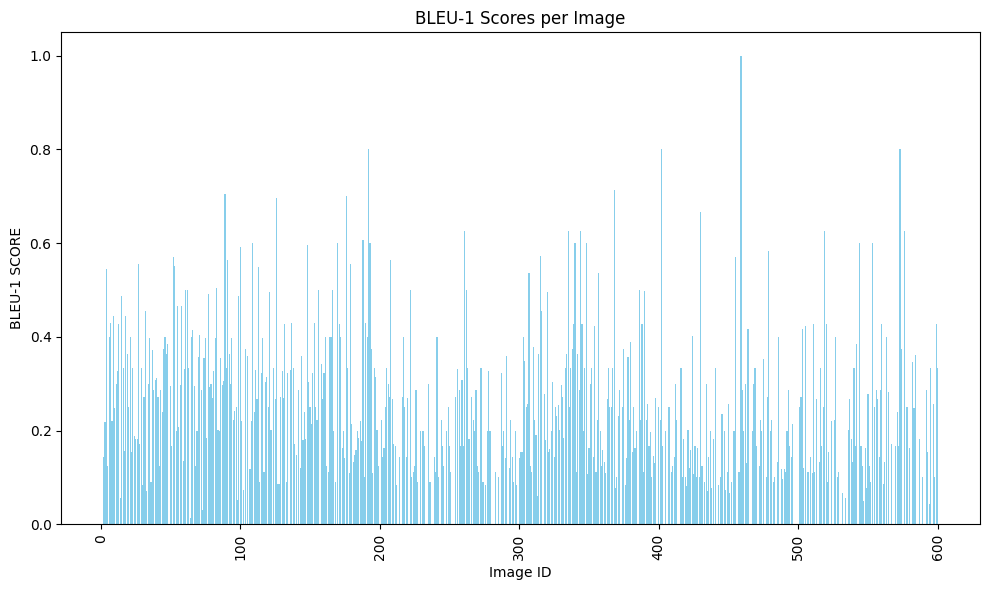

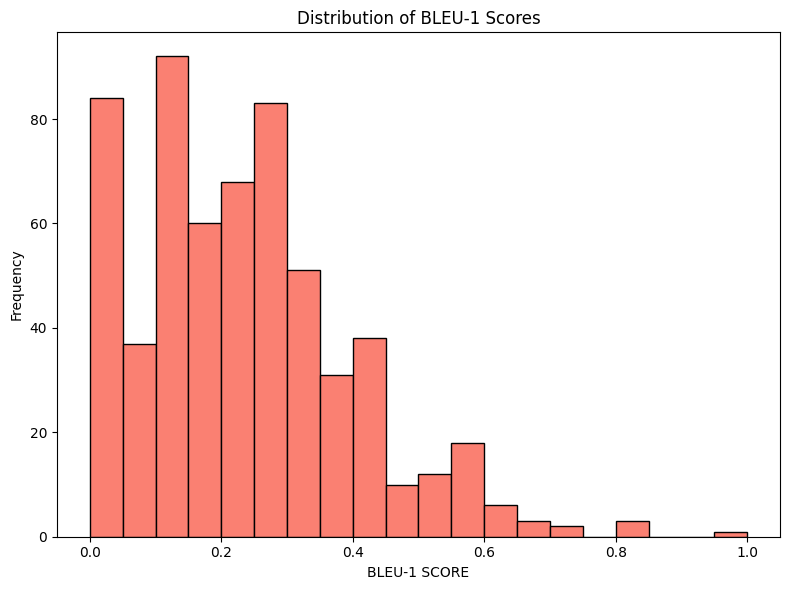

In [261]:
groundtruth_file = "./captions/groundtruth-captions.json"  
predictions_file = "./captions/git.json"  
main_func(predictions_file, groundtruth_file,flag = 'bleu-1')

# BLEU-2 Distribution Git with Ground Truth

Average BLEU-2 score:  0.117


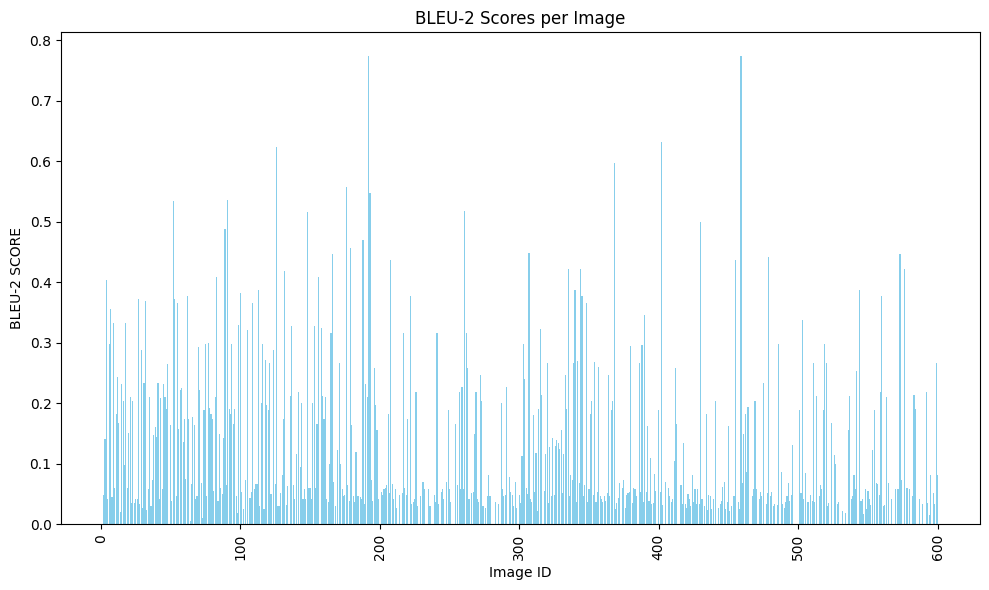

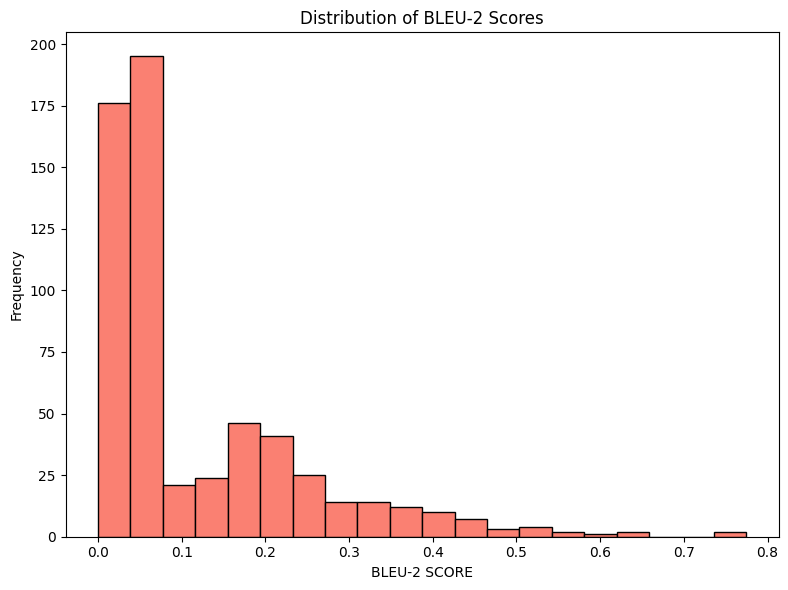

In [262]:
groundtruth_file = "./captions/groundtruth-captions.json"  
predictions_file = "./captions/git.json"  
main_func(predictions_file, groundtruth_file,flag = 'bleu-2')

# METEOR Distribution blip-unconditional with Ground Truth

Average METEOR score:  0.2426


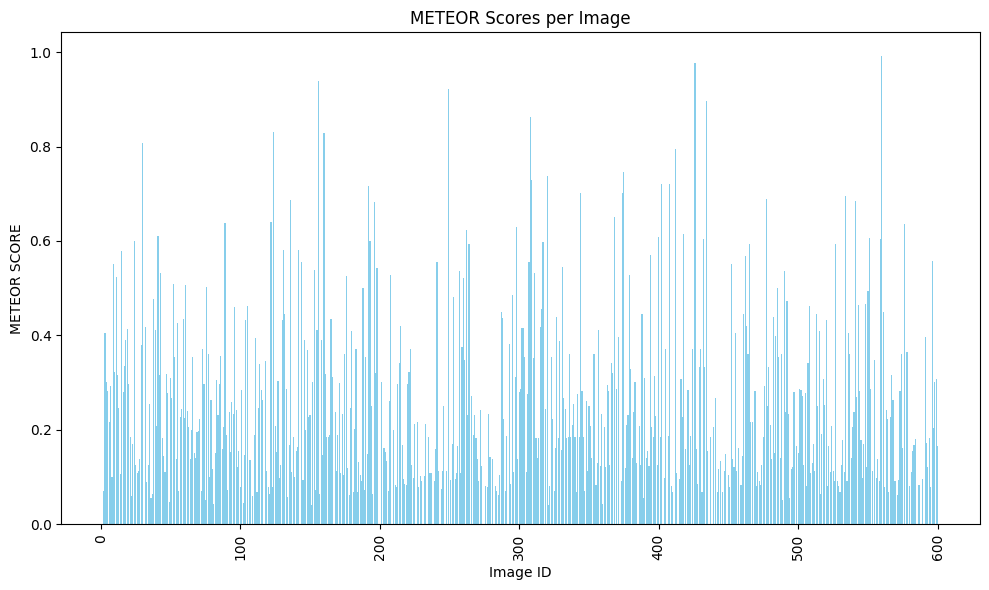

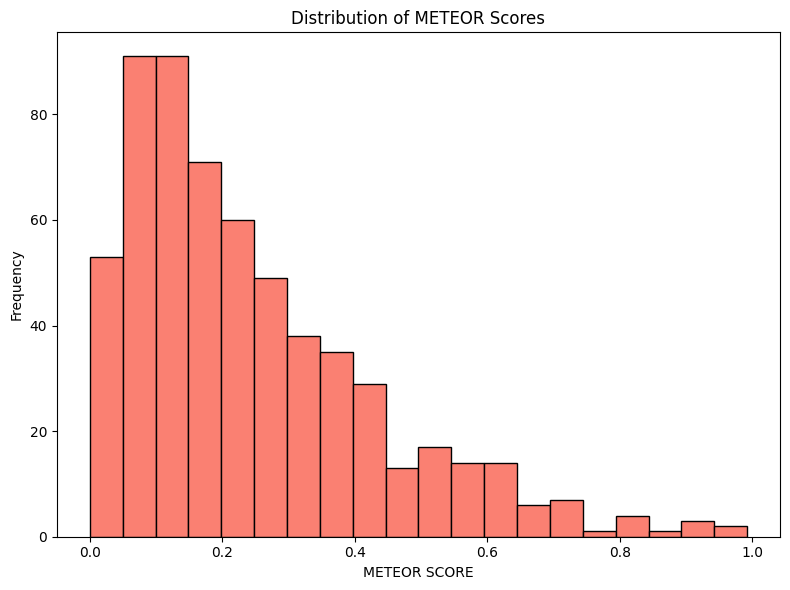

In [263]:
groundtruth_file = "./captions/groundtruth-captions.json"  
predictions_file = "./captions/blip-unconditional-captions.json"  
main_func(predictions_file, groundtruth_file,flag ='meteor')

# BLEU-1 Distribution blip-unconditional with Ground Truth

Average BLEU-1 score:  0.2555


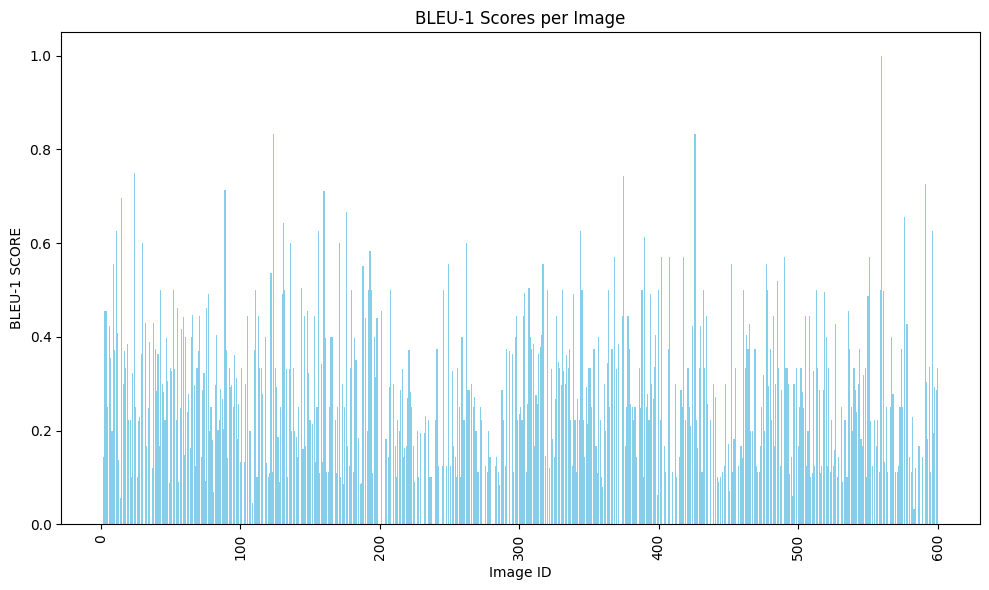

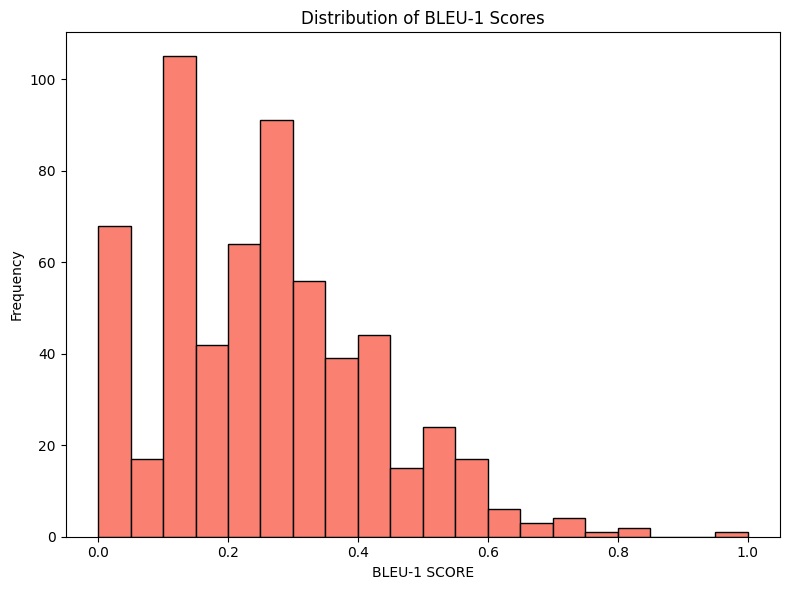

In [264]:
groundtruth_file = "./captions/groundtruth-captions.json"  
predictions_file = "./captions/blip-unconditional-captions.json"  
main_func(predictions_file, groundtruth_file,flag ='bleu-1')

# BLEU-2 Distribution blip-unconditional with Ground Truth

Average BLEU-2 score:  0.1327


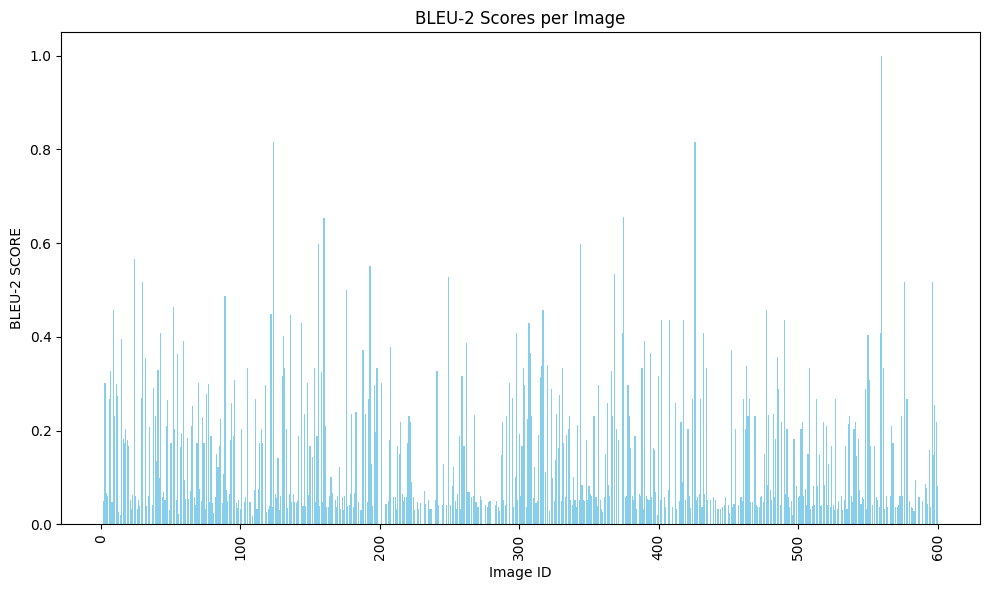

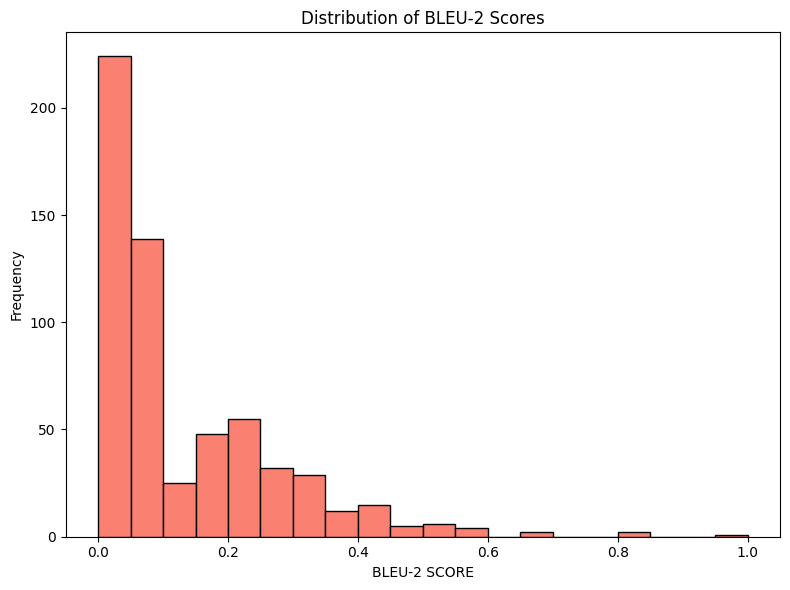

In [265]:
groundtruth_file = "./captions/groundtruth-captions.json"  
predictions_file = "./captions/blip-unconditional-captions.json"  
main_func(predictions_file, groundtruth_file,flag = 'bleu-2')

# METEOR Distribution blip-conditional with Ground Truth

Average METEOR score:  0.2418


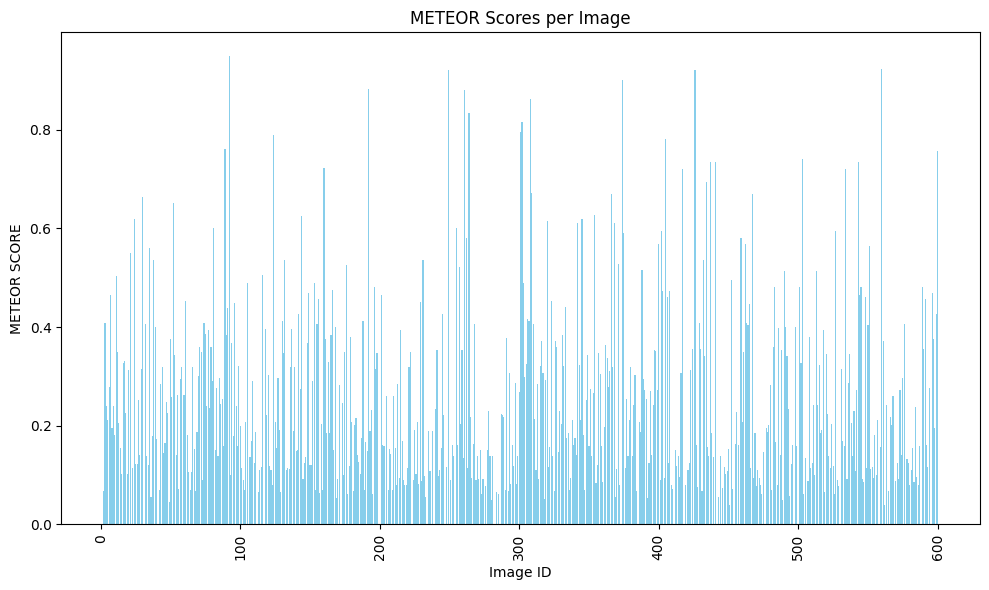

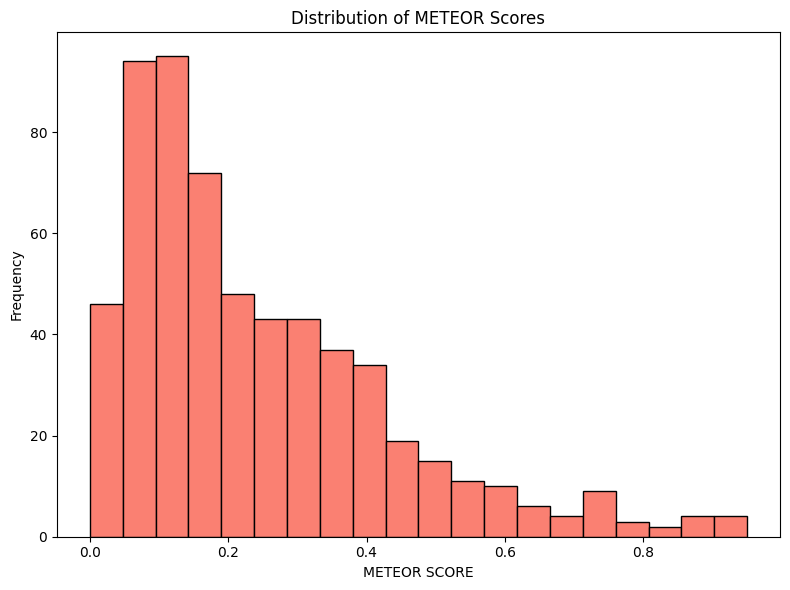

In [266]:
groundtruth_file = "./captions/groundtruth-captions.json"  
predictions_file = "./captions/blip-conditional-captions.json"  
main_func(predictions_file, groundtruth_file,flag ='meteor')

# BLEU-1 Distribution blip-conditional with Ground Truth

Average BLEU-1 score:  0.2357


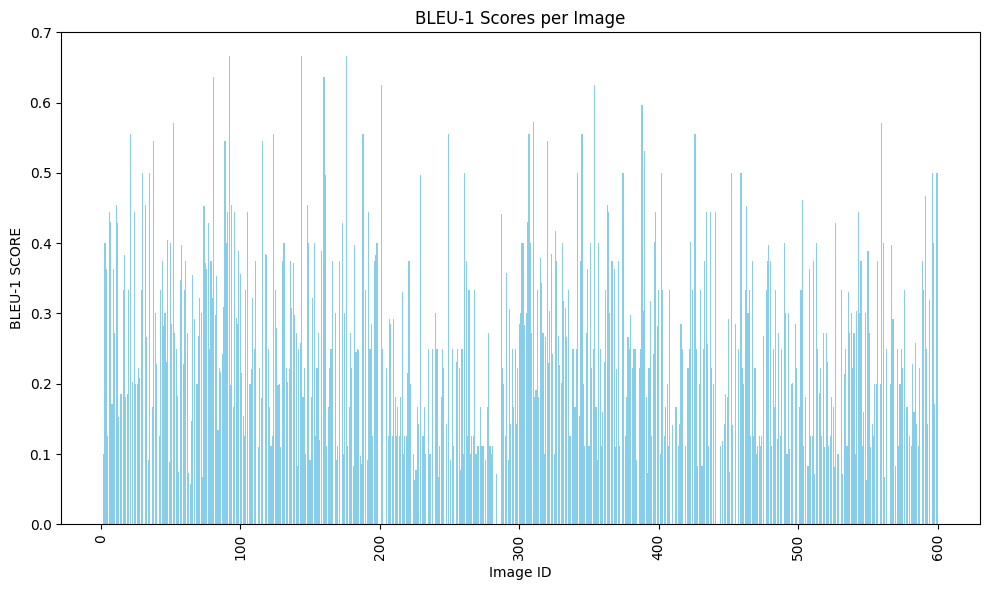

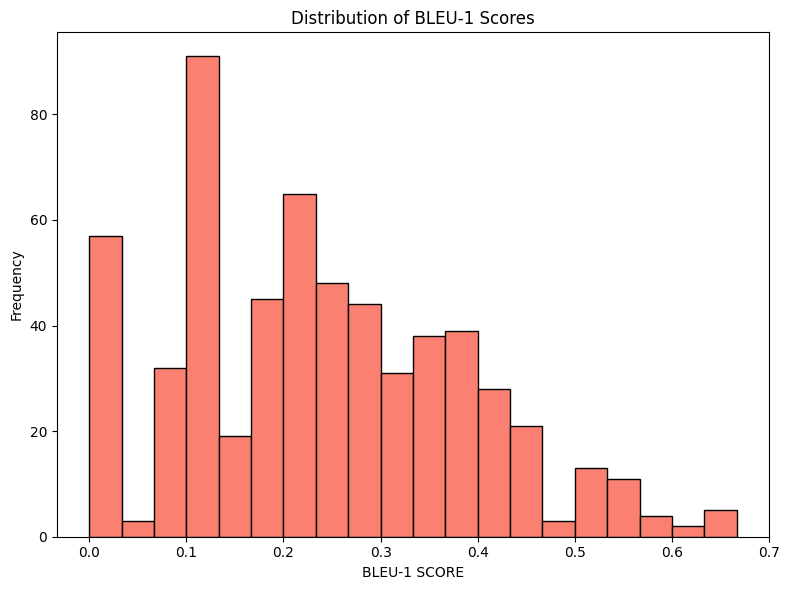

In [267]:
groundtruth_file = "./captions/groundtruth-captions.json"  
predictions_file = "./captions/blip-conditional-captions.json"  
main_func(predictions_file, groundtruth_file,flag ='bleu-1')

# BLEU-2 Distribution blip-conditional with Ground Truth

Average BLEU-2 score:  0.1246


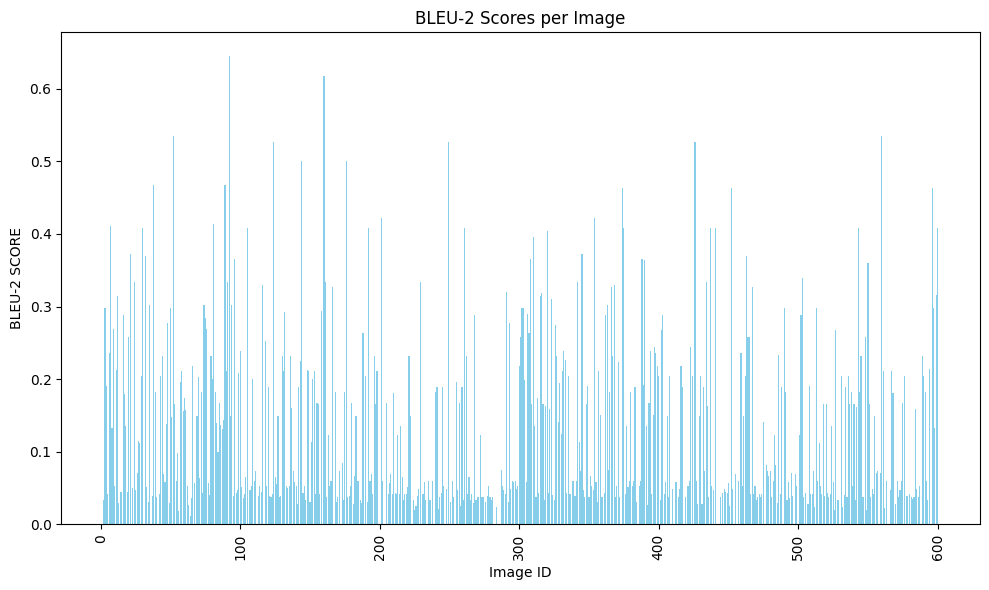

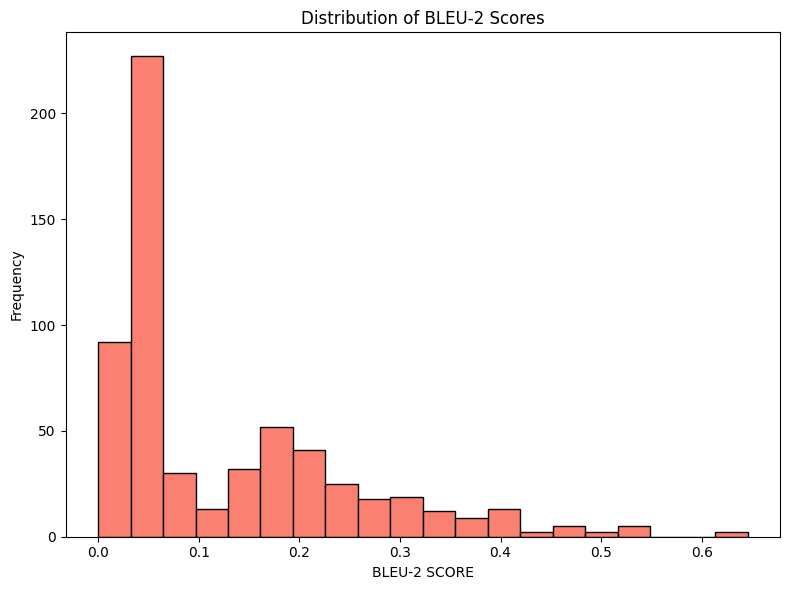

In [268]:
groundtruth_file = "./captions/groundtruth-captions.json"  
predictions_file = "./captions/blip-conditional-captions.json"  
main_func(predictions_file, groundtruth_file,flag = 'bleu-2')

# Combined METEOR Comparison

In [ ]:
def _calculate_average_score(scores):         
    if scores:
        total_score = sum(scores.values())
        average_meteor = total_score / len(scores)
        average_meteor = round(average_meteor, 4)
        print(f"Average score {average_meteor}")
        return average_meteor
    else:
        print("No METEOR scores were calculated.")
        sys.exit(1)




def visualize_average_meteor(models_averages, output_file='average_meteor_comparison.png'):
    """Visualize average METEOR scores for multiple models."""
    models = list(models_averages.keys())
    averages = list(models_averages.values())

    plt.figure(figsize=(12, 8))
    bars = plt.bar(models, averages, color=plt.cm.tab20.colors[:len(models)])
    plt.xlabel('Models')
    plt.ylabel('Average METEOR Score')
    plt.title('Average METEOR Scores Comparison')
    plt.ylim(0, 1)

    # Add value labels on top of bars
    for bar, avg in zip(bars, averages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{avg}', ha='center', va='bottom')

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    # plt.savefig(output_file)
    plt.show()
    plt.close()
    print(f"Average METEOR comparison saved as '{output_file}'.")


def visualize_meteor_distributions(models_scores, output_file='meteor_distributions_comparison.png'):
    """Visualize METEOR score distributions for multiple models."""
    plt.figure(figsize=(12, 8))

    for model, scores in models_scores.items():
        score_values = list(scores.values())
        plt.hist(score_values, bins=20, alpha=0.5, label=model)

    plt.xlabel('METEOR Score')
    plt.ylabel('Frequency')
    plt.title('METEOR Score Distributions Comparison')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    # plt.savefig(output_file)
    plt.close()
    print(f"METEOR distributions comparison saved as '{output_file}'.")


def visualize_boxplot_meteor(models_scores, output_file='meteor_boxplot_comparison.png'):
    """Visualize boxplots of METEOR scores for multiple models."""
    plt.figure(figsize=(12, 8))

    data = [list(scores.values()) for scores in models_scores.values()]
    models = list(models_scores.keys())

    plt.boxplot(data, labels=models, patch_artist=True,
                boxprops=dict(facecolor='lightblue'),
                medianprops=dict(color='red'))

    plt.xlabel('Models')
    plt.ylabel('METEOR Score')
    plt.title('METEOR Scores Boxplot Comparison')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    # plt.savefig(output_file)
    plt.close()
    print(f"METEOR boxplot comparison saved as '{output_file}'.")


def compare_models(groundtruth_file, predictions_files, model_names=None):
    """
    Compare multiple models by computing and visualizing their METEOR scores.

    :param groundtruth_file: Path to ground truth JSON file.
    :param predictions_files: List of prediction JSON file paths.
    :param model_names: Optional list of model names. If None, filenames are used.
    """
    if model_names is None:
        model_names = [f.split('.')[0] for f in predictions_files]

    ground_truth = load_annotations(groundtruth_file)

    models_scores = {}
    models_averages = {}


    for model, pred_file in zip(model_names, predictions_files):
        print(f"Processing model: {model}")
        predicted = load_annotations(pred_file)
        scores = compute_meteor_scores(ground_truth, predicted)
        average = _calculate_average_score(scores)
        if average is not None:
            models_scores[model] = scores
            models_averages[model] = average
            print(f"{model} - Average METEOR: {average}")
        else:
            print(f"{model} - No scores to average.")

    # Visualize average METEOR scores
    visualize_average_meteor(models_averages)

    # Visualize METEOR score distributions
    visualize_meteor_distributions(models_scores)

    # Visualize boxplot of METEOR scores
    visualize_boxplot_meteor(models_scores)





Processing model: blip-unconditional-captions
Average score 0.2426
blip-unconditional-captions - Average METEOR: 0.2426
Processing model: git
Average score 0.2207
git - Average METEOR: 0.2207
Processing model: blip-conditional-captions
Average score 0.2418
blip-conditional-captions - Average METEOR: 0.2418
Processing model: vit-gpt2-captions
Average score 0.1644
vit-gpt2-captions - Average METEOR: 0.1644


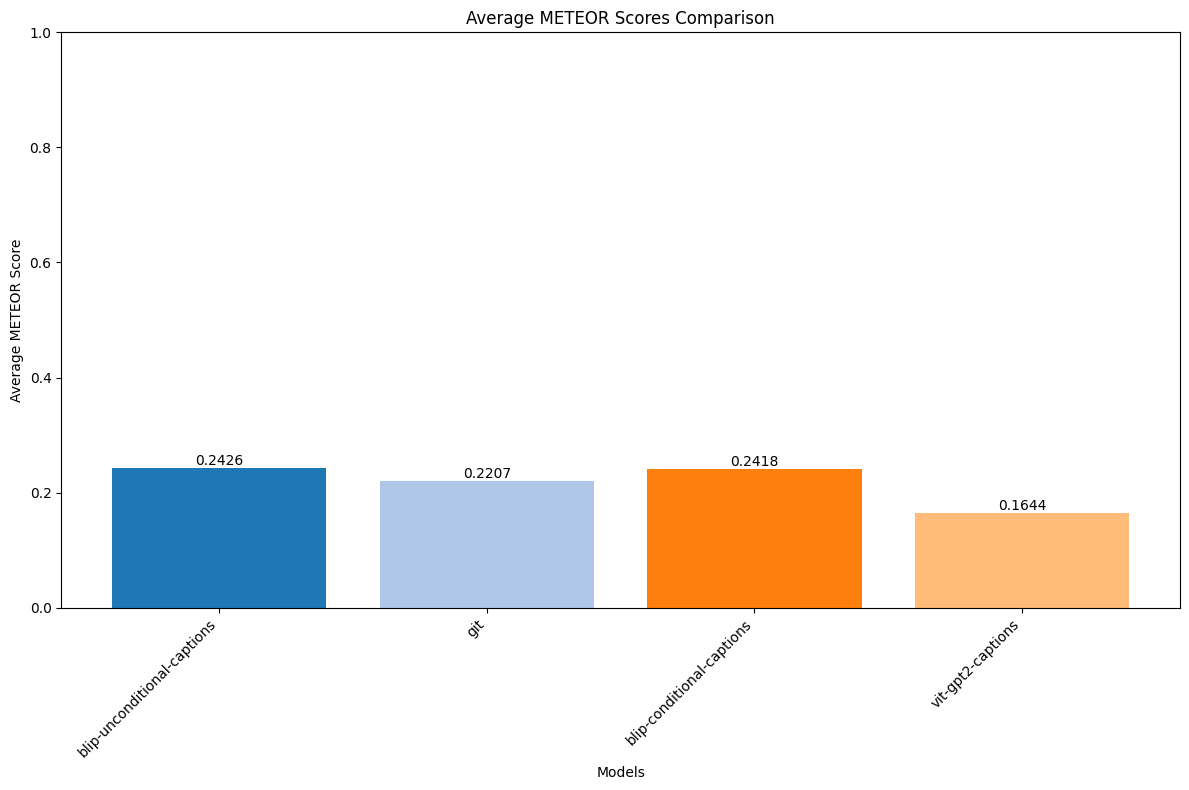

Average METEOR comparison saved as 'average_meteor_comparison.png'.


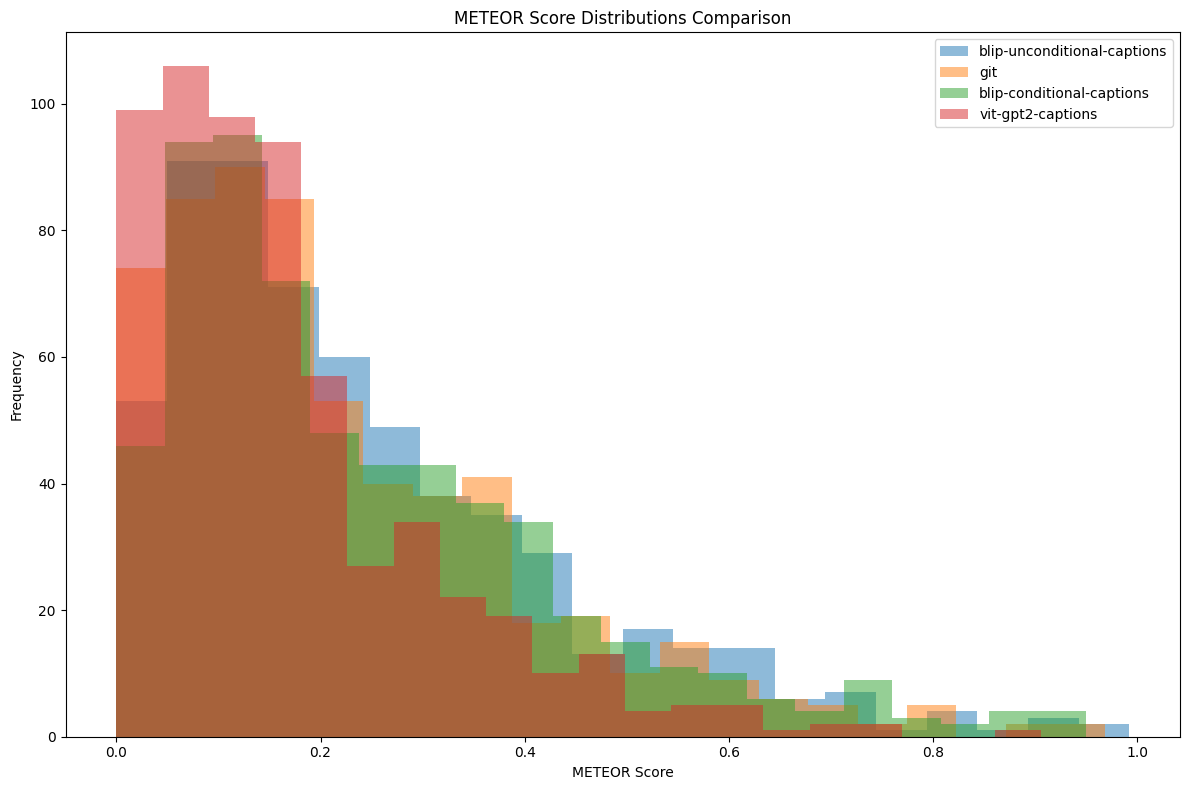

METEOR distributions comparison saved as 'meteor_distributions_comparison.png'.


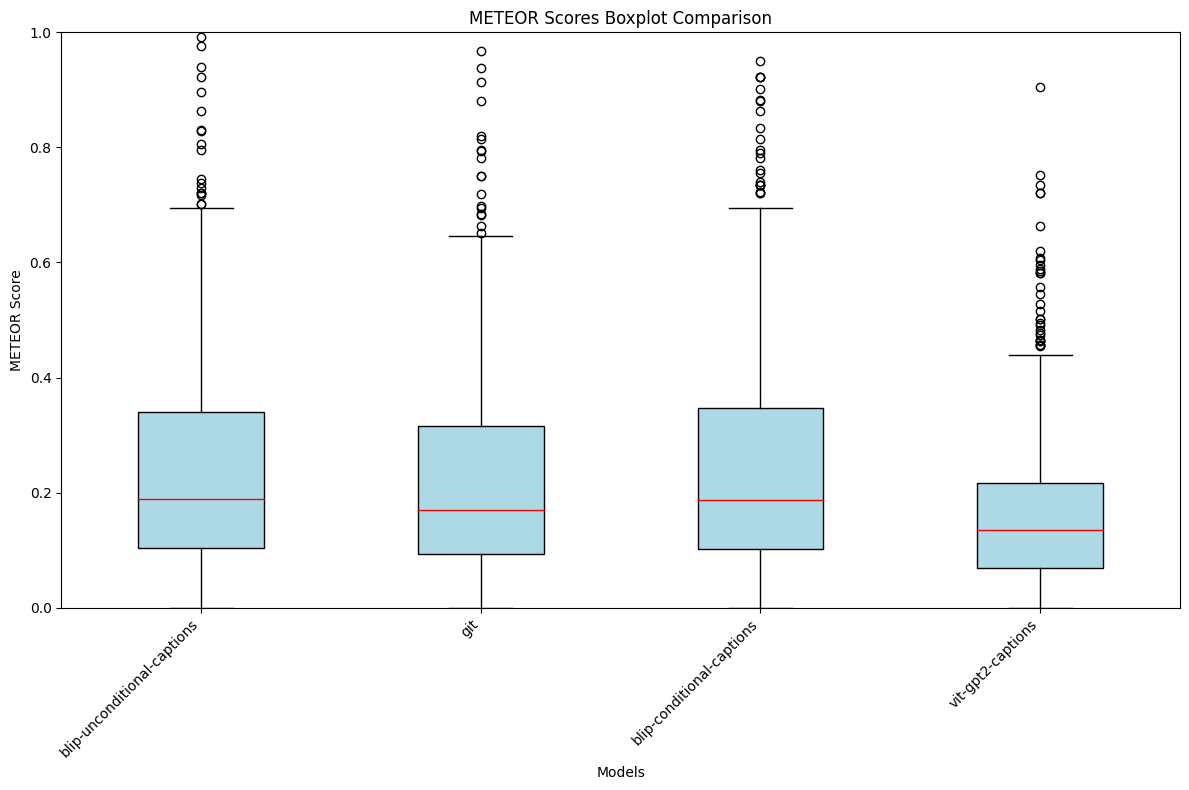

METEOR boxplot comparison saved as 'meteor_boxplot_comparison.png'.


In [272]:
groundtruth_file = "./captions/groundtruth-captions.json"  
predictions_files = ["./captions/blip-unconditional-captions.json","./captions/git.json","./captions/blip-conditional-captions.json" ,"./captions/vit-gpt2-captions.json"   ]
compare_models(groundtruth_file, predictions_files, model_names = ['blip-unconditional-captions','git','blip-conditional-captions','vit-gpt2-captions'])

# Combined BLEU-1 Comparison

In [281]:
def _calculate_average_bleu(scores):         
    if scores:
        total_score = sum(scores.values())
        average_bleu = total_score / len(scores)
        average_bleu = round(average_bleu, 4)
        print(f"Average BLEU-1 score: {average_bleu}")
        return average_bleu
    else:
        print("No BLEU-1 scores were calculated.")
        sys.exit(1)


def visualize_average_bleu(models_averages, output_file='average_bleu_comparison.png'):
    """Visualize average BLEU-1 scores for multiple models."""
    models = list(models_averages.keys())
    averages = list(models_averages.values())

    plt.figure(figsize=(12, 8))
    bars = plt.bar(models, averages, color=plt.cm.tab20.colors[:len(models)])
    plt.xlabel('Models')
    plt.ylabel('Average BLEU-1 Score')
    plt.title('Average BLEU-1 Scores Comparison')
    plt.ylim(0, 1)

    # Add value labels on top of bars
    for bar, avg in zip(bars, averages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{avg}', ha='center', va='bottom')

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    plt.close()
    print(f"Average BLEU-1 comparison saved as '{output_file}'.")


def visualize_bleu_distributions(models_scores, output_file='bleu_distributions_comparison.png'):
    """Visualize BLEU-1 score distributions for multiple models."""
    plt.figure(figsize=(12, 8))

    for model, scores in models_scores.items():
        score_values = list(scores.values())
        plt.hist(score_values, bins=20, alpha=0.5, label=model)

    plt.xlabel('BLEU-1 Score')
    plt.ylabel('Frequency')
    plt.title('BLEU-1 Score Distributions Comparison')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    plt.close()
    print(f"BLEU-1 distributions comparison saved as '{output_file}'.")


def visualize_boxplot_bleu(models_scores, output_file='bleu_boxplot_comparison.png'):
    """Visualize boxplots of BLEU-1 scores for multiple models."""
    plt.figure(figsize=(12, 8))

    data = [list(scores.values()) for scores in models_scores.values()]
    models = list(models_scores.keys())

    plt.boxplot(data, labels=models, patch_artist=True,
                boxprops=dict(facecolor='lightblue'),
                medianprops=dict(color='red'))

    plt.xlabel('Models')
    plt.ylabel('BLEU-1 Score')
    plt.title('BLEU-1 Scores Boxplot Comparison')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    plt.close()
    print(f"BLEU-1 boxplot comparison saved as '{output_file}'.")


def compare_models_bleu1(groundtruth_file, predictions_files, model_names=None):
    """
    Compare multiple models by computing and visualizing their BLEU-1 scores.

    :param groundtruth_file: Path to ground truth JSON file.
    :param predictions_files: List of prediction JSON file paths.
    :param model_names: Optional list of model names. If None, filenames are used.
    """
    if model_names is None:
        model_names = [f.split('.')[0] for f in predictions_files]

    ground_truth = load_annotations(groundtruth_file)

    models_scores = {}
    models_averages = {}

    for model, pred_file in zip(model_names, predictions_files):
        print(f"Processing model: {model}")
        predicted = load_annotations(pred_file)
        scores = compute_bleu_scores(ground_truth, predicted,1)  # Ensure BLEU-1 scoring function is implemented
        average = _calculate_average_bleu(scores)
        if average is not None:
            models_scores[model] = scores
            models_averages[model] = average
            print(f"{model} - Average BLEU-1: {average}")
        else:
            print(f"{model} - No scores to average.")

    # Visualize average BLEU-1 scores
    visualize_average_bleu(models_averages)

    # Visualize BLEU-1 score distributions
    visualize_bleu_distributions(models_scores)

    # Visualize boxplot of BLEU-1 scores
    visualize_boxplot_bleu(models_scores)

Processing model: blip-unconditional-captions
Average BLEU-1 score: 0.2555
blip-unconditional-captions - Average BLEU-1: 0.2555
Processing model: git
Average BLEU-1 score: 0.2301
git - Average BLEU-1: 0.2301
Processing model: blip-conditional-captions
Average BLEU-1 score: 0.2357
blip-conditional-captions - Average BLEU-1: 0.2357
Processing model: vit-gpt2-captions
Average BLEU-1 score: 0.1845
vit-gpt2-captions - Average BLEU-1: 0.1845


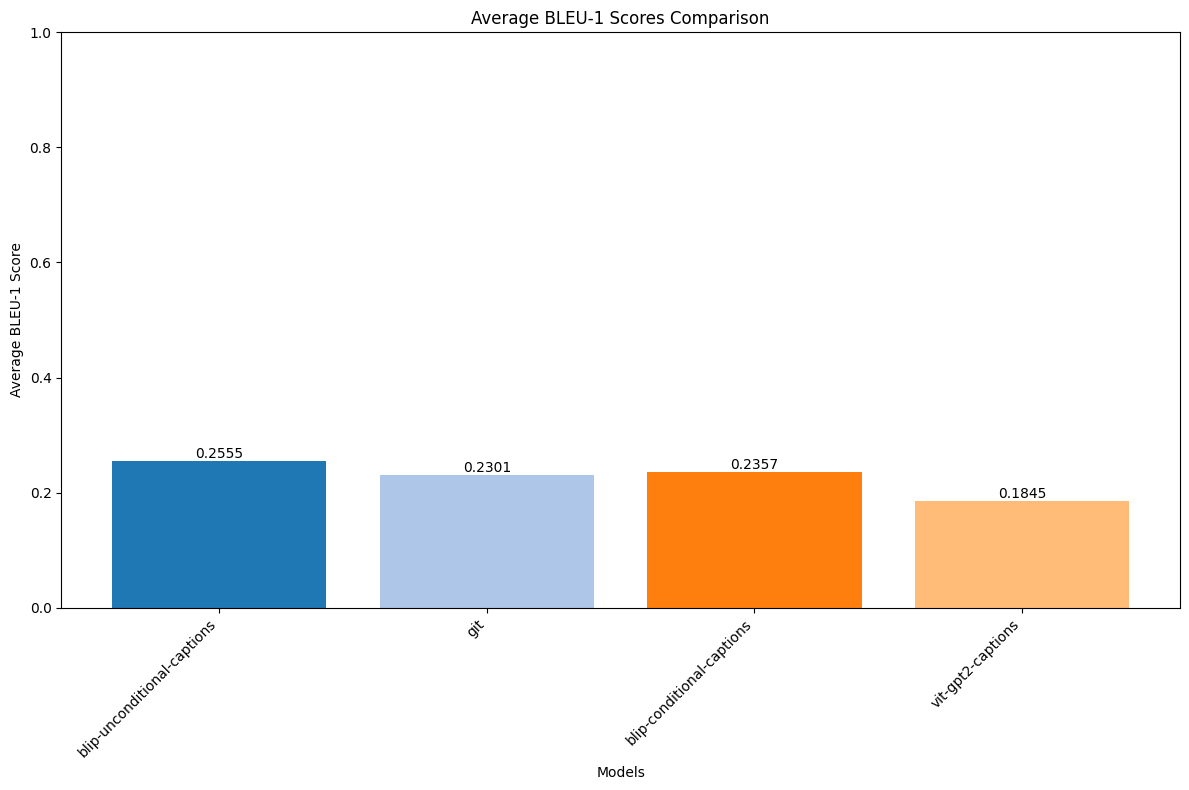

Average BLEU-1 comparison saved as 'average_bleu_comparison.png'.


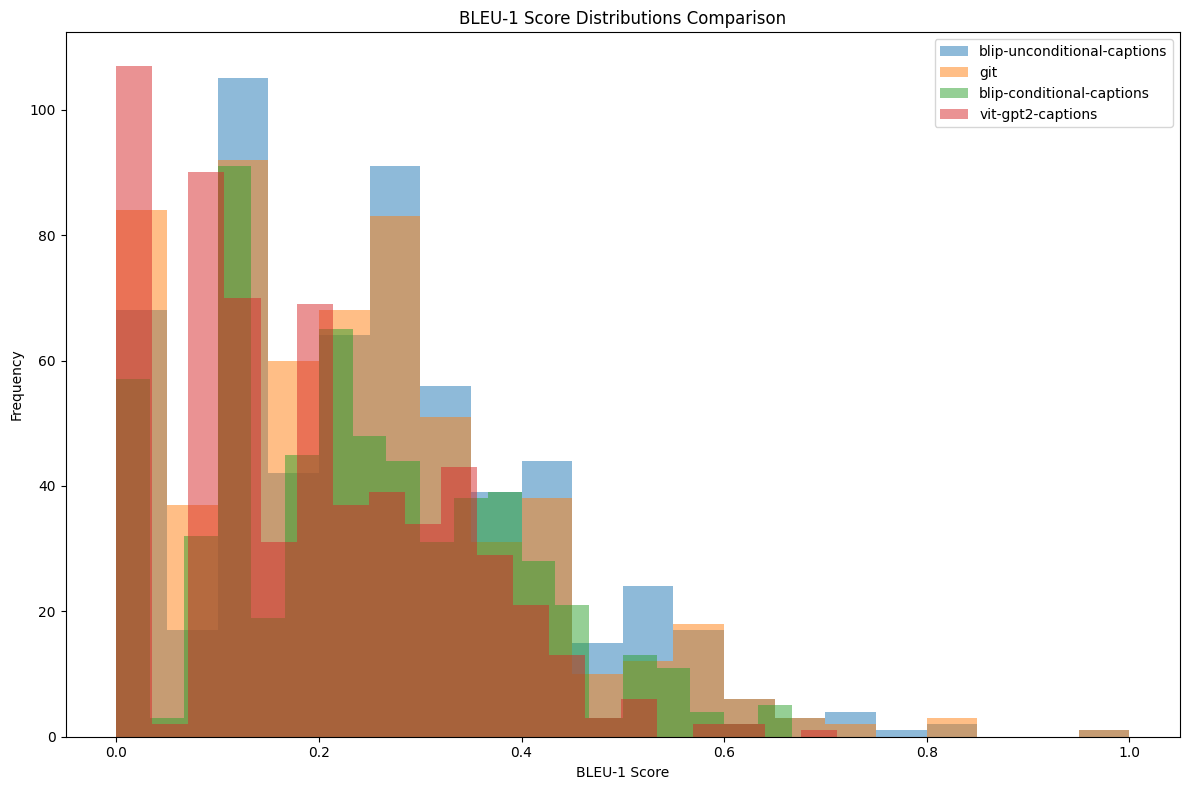

BLEU-1 distributions comparison saved as 'bleu_distributions_comparison.png'.


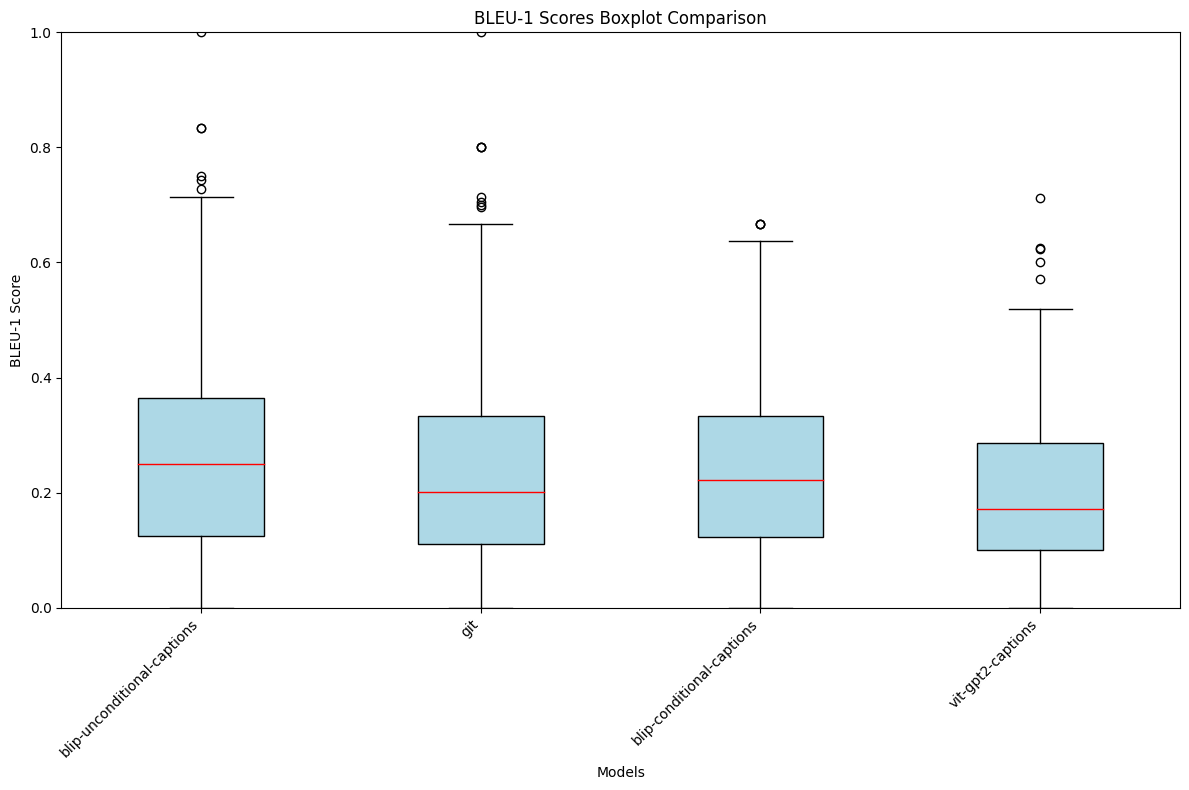

BLEU-1 boxplot comparison saved as 'bleu_boxplot_comparison.png'.


In [282]:
groundtruth_file = "./captions/groundtruth-captions.json"  
predictions_files = ["./captions/blip-unconditional-captions.json","./captions/git.json","./captions/blip-conditional-captions.json" ,"./captions/vit-gpt2-captions.json"   ]
compare_models_bleu1(groundtruth_file, predictions_files, model_names = ['blip-unconditional-captions','git','blip-conditional-captions','vit-gpt2-captions'])

In [284]:
def _calculate_average_bleu2(scores):         
    if scores:
        total_score = sum(scores.values())
        average_bleu2 = total_score / len(scores)
        average_bleu2 = round(average_bleu2, 4)
        print(f"Average BLEU-2 score: {average_bleu2}")
        return average_bleu2
    else:
        print("No BLEU-2 scores were calculated.")
        sys.exit(1)


def visualize_average_bleu2(models_averages, output_file='average_bleu2_comparison.png'):
    """Visualize average BLEU-2 scores for multiple models."""
    models = list(models_averages.keys())
    averages = list(models_averages.values())

    plt.figure(figsize=(12, 8))
    bars = plt.bar(models, averages, color=plt.cm.tab20.colors[:len(models)])
    plt.xlabel('Models')
    plt.ylabel('Average BLEU-2 Score')
    plt.title('Average BLEU-2 Scores Comparison')
    plt.ylim(0, 1)

    # Add value labels on top of bars
    for bar, avg in zip(bars, averages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{avg}', ha='center', va='bottom')

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    plt.close()
    print(f"Average BLEU-2 comparison saved as '{output_file}'.")


def visualize_bleu2_distributions(models_scores, output_file='bleu2_distributions_comparison.png'):
    """Visualize BLEU-2 score distributions for multiple models."""
    plt.figure(figsize=(12, 8))

    for model, scores in models_scores.items():
        score_values = list(scores.values())
        plt.hist(score_values, bins=20, alpha=0.5, label=model)

    plt.xlabel('BLEU-2 Score')
    plt.ylabel('Frequency')
    plt.title('BLEU-2 Score Distributions Comparison')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    plt.close()
    print(f"BLEU-2 distributions comparison saved as '{output_file}'.")


def visualize_boxplot_bleu2(models_scores, output_file='bleu2_boxplot_comparison.png'):
    """Visualize boxplots of BLEU-2 scores for multiple models."""
    plt.figure(figsize=(12, 8))

    data = [list(scores.values()) for scores in models_scores.values()]
    models = list(models_scores.keys())

    plt.boxplot(data, labels=models, patch_artist=True,
                boxprops=dict(facecolor='lightblue'),
                medianprops=dict(color='red'))

    plt.xlabel('Models')
    plt.ylabel('BLEU-2 Score')
    plt.title('BLEU-2 Scores Boxplot Comparison')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    plt.close()
    print(f"BLEU-2 boxplot comparison saved as '{output_file}'.")


def compare_models_bleu2(groundtruth_file, predictions_files, model_names=None):
    """
    Compare multiple models by computing and visualizing their BLEU-2 scores.

    :param groundtruth_file: Path to ground truth JSON file.
    :param predictions_files: List of prediction JSON file paths.
    :param model_names: Optional list of model names. If None, filenames are used.
    """
    if model_names is None:
        model_names = [f.split('.')[0] for f in predictions_files]

    ground_truth = load_annotations(groundtruth_file)

    models_scores = {}
    models_averages = {}

    for model, pred_file in zip(model_names, predictions_files):
        print(f"Processing model: {model}")
        predicted = load_annotations(pred_file)
        scores = compute_bleu_scores(ground_truth, predicted,2)  # Ensure BLEU-2 scoring function is implemented
        average = _calculate_average_bleu2(scores)
        if average is not None:
            models_scores[model] = scores
            models_averages[model] = average
            print(f"{model} - Average BLEU-2: {average}")
        else:
            print(f"{model} - No scores to average.")

    # Visualize average BLEU-2 scores
    visualize_average_bleu2(models_averages)

    # Visualize BLEU-2 score distributions
    visualize_bleu2_distributions(models_scores)

    # Visualize boxplot of BLEU-2 scores
    visualize_boxplot_bleu2(models_scores)

Processing model: blip-unconditional-captions
Average BLEU-2 score: 0.1327
blip-unconditional-captions - Average BLEU-2: 0.1327
Processing model: git
Average BLEU-2 score: 0.117
git - Average BLEU-2: 0.117
Processing model: blip-conditional-captions
Average BLEU-2 score: 0.1246
blip-conditional-captions - Average BLEU-2: 0.1246
Processing model: vit-gpt2-captions
Average BLEU-2 score: 0.0816
vit-gpt2-captions - Average BLEU-2: 0.0816


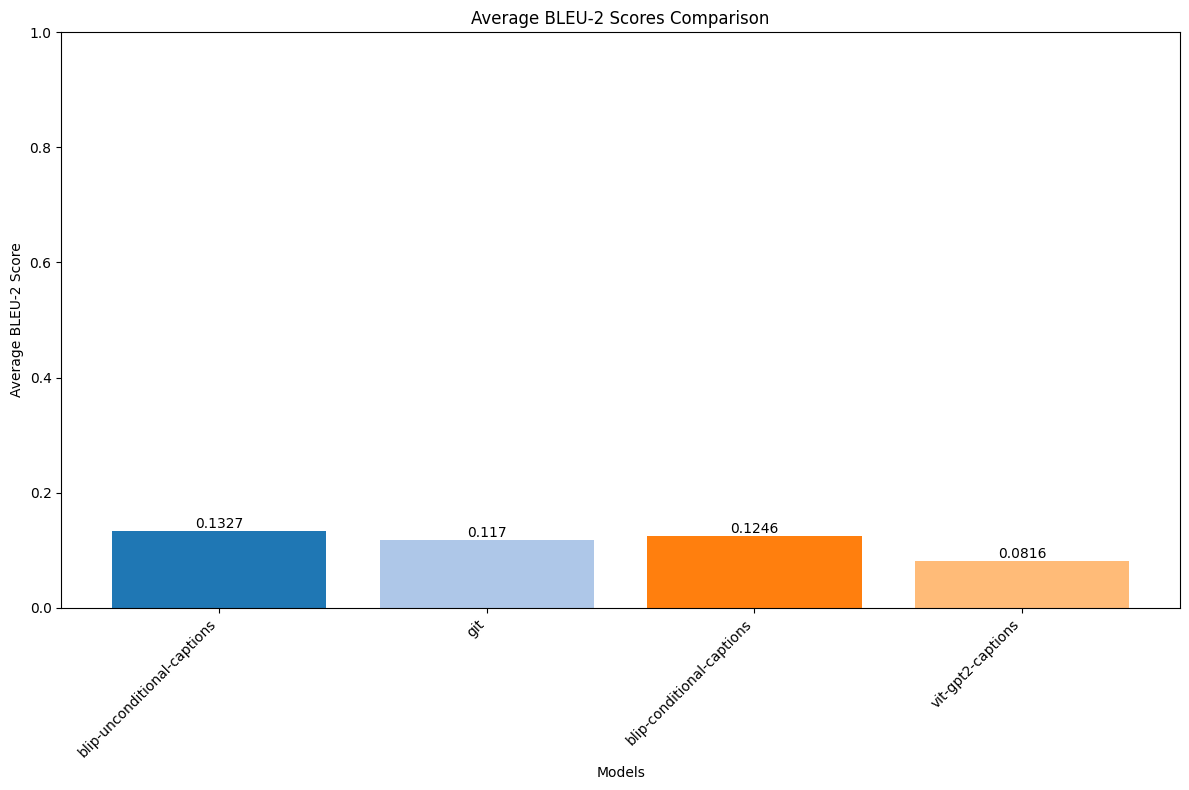

Average BLEU-2 comparison saved as 'average_bleu2_comparison.png'.


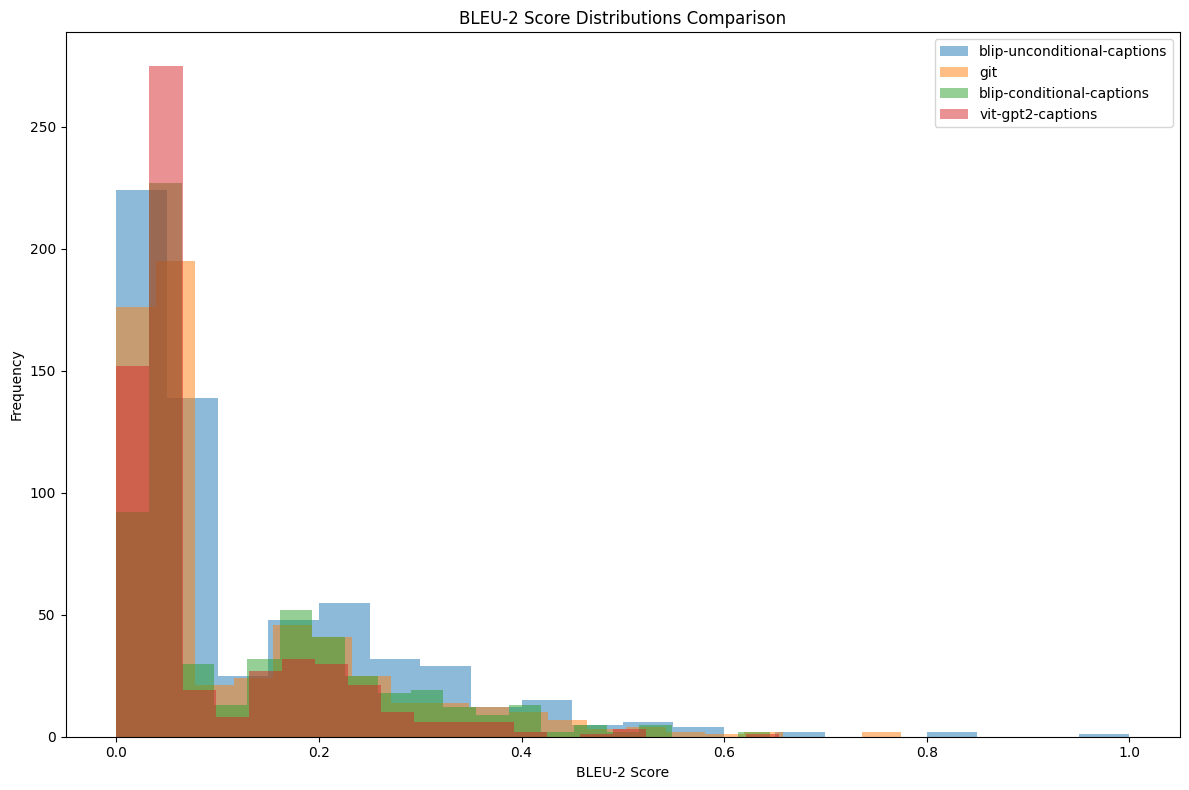

BLEU-2 distributions comparison saved as 'bleu2_distributions_comparison.png'.


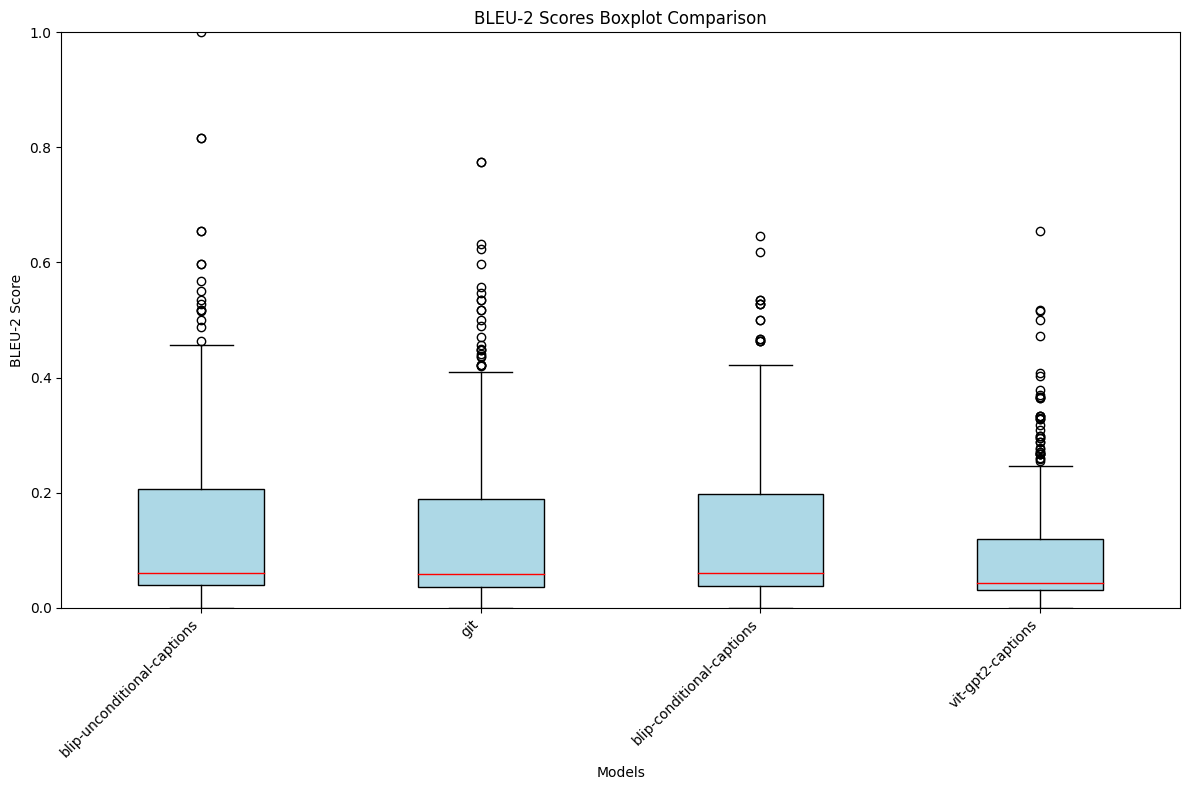

BLEU-2 boxplot comparison saved as 'bleu2_boxplot_comparison.png'.


In [285]:
groundtruth_file = "./captions/groundtruth-captions.json"  
predictions_files = ["./captions/blip-unconditional-captions.json","./captions/git.json","./captions/blip-conditional-captions.json" ,"./captions/vit-gpt2-captions.json"   ]
compare_models_bleu2(groundtruth_file, predictions_files, model_names = ['blip-unconditional-captions','git','blip-conditional-captions','vit-gpt2-captions'])